In [1]:
# import libraries

import numpy as np
import os
import urllib
from time import time
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.manifold as mani
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import eye
from PIL import Image

# load data

from mnist import MNIST
mndata = MNIST('./../data/')
[Xtrain,Ytrain] = mndata.load_training()
#[Xtest, Ytest] = mndata.load_testing()
#digits = load_digits()

# I got this from 
# http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py 
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    fig = plt.figure()
    
    if(len(X[0]) == 2):
        ax2D = fig.add_subplot(111)
        for i in range(X.shape[0]):
            ax2D.text(X[i, 0], X[i, 1], str(Ytrain[i]),
                 color=plt.cm.Set1(Ytrain[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    elif(len(X[0]) == 3):
        ax3D = fig.add_subplot(111,projection='3d')
        for i in range(X.shape[0]):
            ax3D.text(X[i, 0], X[i, 1], X[i,2], str(Ytrain[i]),
                 color=plt.cm.Set1(Ytrain[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
#----------------------------------------------------------------------

Done. Reconstruction error: 0.00013692


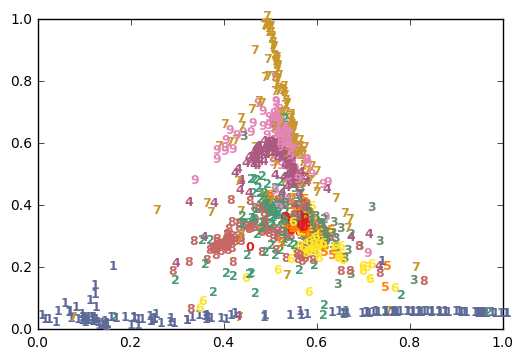

Done. Reconstruction error: 0.000434062


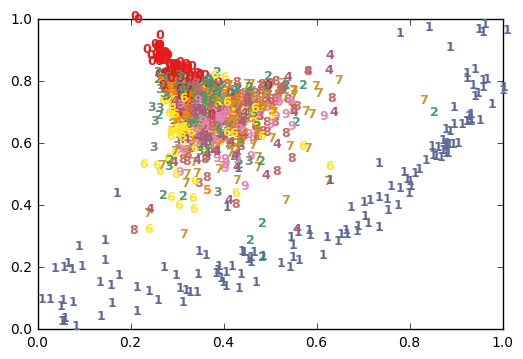

In [82]:
# section b)

for n_neighbours in [10,30]:
    for n_components in [2]:
        clf = LocallyLinearEmbedding(n_neighbors=n_neighbours, n_components=n_components,
                                      method='standard')
        t0 = time()
        X_lle = clf.fit_transform(Xtrain[0:1200])
        print("Done. Reconstruction error: %g" % clf.reconstruction_error_)

        plot_embedding(X_lle,
                       "LLE of digits. n_neighbours = " + str(n_neighbours) + ", n_components = " + str(n_components) + " (time %.2fs)" %
                       (time() - t0))
        #plt.savefig('fig' + str(n_neighbours) + "_" + str(n_components))
        plt.show()

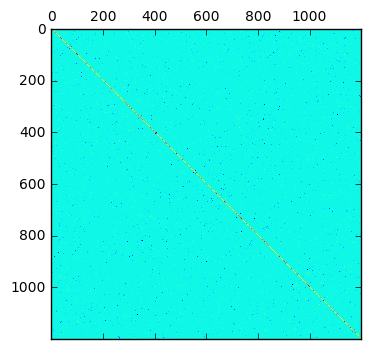

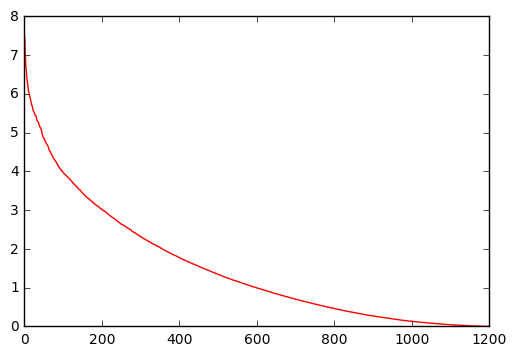

In [74]:
# section c)

W = mani.locally_linear.barycenter_kneighbors_graph(Xtrain[0:1200],30)
I = np.identity(W.shape[0],dtype=float)

M = np.transpose(I - W)*(I - W)

# calc sing values

plt.matshow(M)
#plt.savefig('figM')
plt.show()

EV = np.linalg.svd(M)[1]

plt.plot(range(0,1200), EV, 'r-')
#plt.savefig('figEV')
plt.show()


Done. Reconstruction error: 5.68152e-07


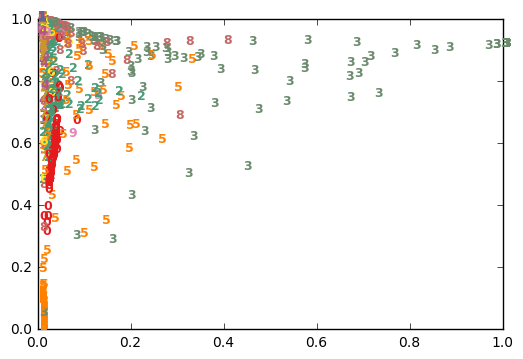

Done. Reconstruction error: 8.91564e-05


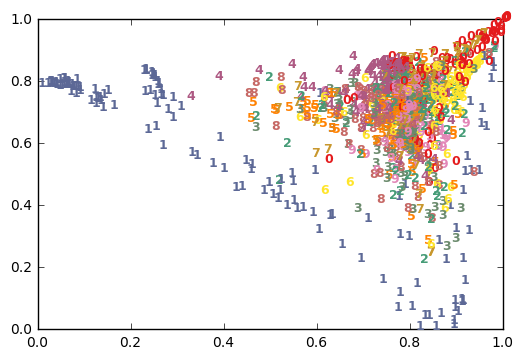

Done. Reconstruction error: 0.000136925


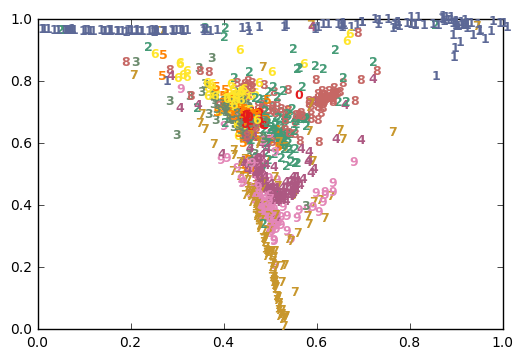

Done. Reconstruction error: 0.000153019


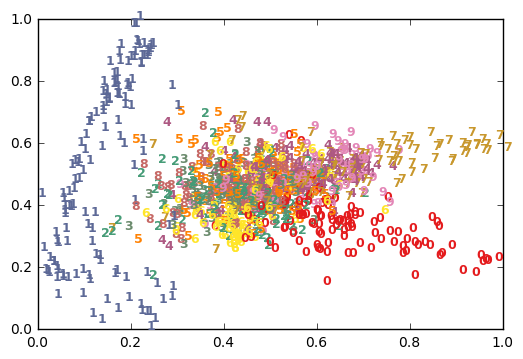

Done. Reconstruction error: 0.000284771


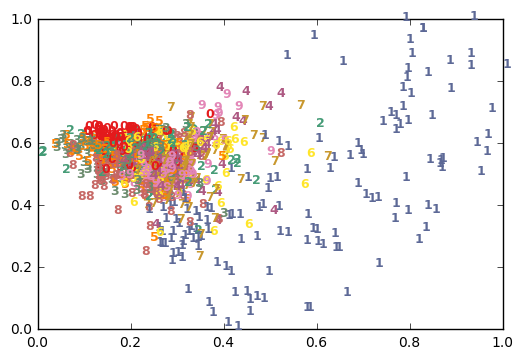

Done. Reconstruction error: 2.91062e-05


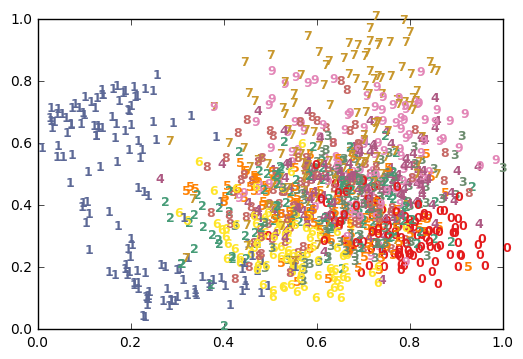

In [18]:
# section d)

def locally_linear_embedding(
        X, n_neighbors, n_components, reg=1e-3, eigen_solver='auto', tol=1e-6,
        max_iter=100, method='standard', hessian_tol=1E-4, modified_tol=1E-12,
        random_state=None, n_jobs=1, metric = 'minkowski'):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs,metric = metric)
    nbrs.fit(X)
    X = nbrs._fit_X
    N, d_in = X.shape
    M_sparse = (eigen_solver != 'dense')
    W = mani.locally_linear.barycenter_kneighbors_graph(
        nbrs, n_neighbors=n_neighbors, reg=reg)

    # we'll compute M = (I-W)'(I-W)
    # depending on the solver, we'll do this differently
    if M_sparse:
        M = eye(*W.shape, format=W.format) - W
        M = (M.T * M).tocsr()
    else:
        M = (W.T * W - W.T - W).toarray()
        M.flat[::M.shape[0] + 1] += 1  # W = W - I = W - I
    return mani.locally_linear.null_space(M, n_components, k_skip=1, eigen_solver=eigen_solver,
        tol=tol, max_iter=max_iter, random_state=random_state)




for n_neighbours in [5,10,50]:
    for metric in ['minkowski', 'chebyshev']:
        t0 = time()
        X_lle = locally_linear_embedding(X = Xtrain[0:1200],n_neighbors=n_neighbours, n_components=2, metric=metric)
        print("Done. Reconstruction error: %g" % X_lle[1])

        plot_embedding(X_lle[0],
                       "LLE of digits. n_neighbours = " + str(n_neighbours) + ", metric = " + metric + " (time %.2fs)" %
                       (time() - t0))
        #plt.savefig('fig' + str(n_neighbours) + "_" + metric)
        plt.show()

In [182]:
# section e)

# calc embedded space
d = 2
K = 10
interpolationAmount = 5
# these points were chosen randomly
point1 = 101
point2 = 121
clf = LocallyLinearEmbedding(n_neighbors=50, n_components=d, method='standard')
X_lle = clf.fit_transform(Xtrain[0:1200])

def reconstruct(X,X_lle_,y_new,K_):
    
    # 1. find K nearest neighbors of y_new
    nbrs = NearestNeighbors(n_neighbors=K_+1, n_jobs=1,metric = 'minkowski')
    nbrs.fit(X_lle_)
    distance,ids = nbrs.kneighbors([y_new])
    NB = X_lle[ids[0][1:]]
    
    # 2. solve NB^Tu^T = y_new^T
    u = np.linalg.lstsq(np.transpose(NB),np.transpose(y_new))[0]
    
    # 3. find original space neighbors
    NB_orig = np.atleast_1d(X)[ids[0][1:]]
    
    # 4. reconstruct x_new
    return np.dot(u,NB_orig)

# pick two y_new in the embedded space 
y_new_1 = X_lle[point1]
y_new_2 = X_lle[point2]

# interpolate between the two points

y = [np.linspace(y_new_1[0], y_new_2[0], num=interpolationAmount),np.linspace(y_new_1[1], y_new_2[1], num=interpolationAmount)]
y = [[x,y] for x,y in zip(y[0],y[1])]

# reconstruct all y 

solution = list(map(lambda y_: reconstruct(Xtrain,X_lle,y_,K), y))

for i in range(0,5):
    plt.imshow(Image.fromarray(solution[i].reshape(28,28)))
    plt.savefig('interpolate_' + str(i))
plt.show()    

# interpolate original images
Xorig = np.transpose([np.linspace(x1,x2, num=interpolationAmount) for x1,x2 in zip(Xtrain[point1],Xtrain[point2])])


for i in range(0,5):
    plt.imshow(Image.fromarray(Xorig[i].reshape(28,28)))
    plt.savefig('interpolate_original_' + str(i))